<a href="https://colab.research.google.com/github/Bushra1423/MedDiagnose/blob/main/skincancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


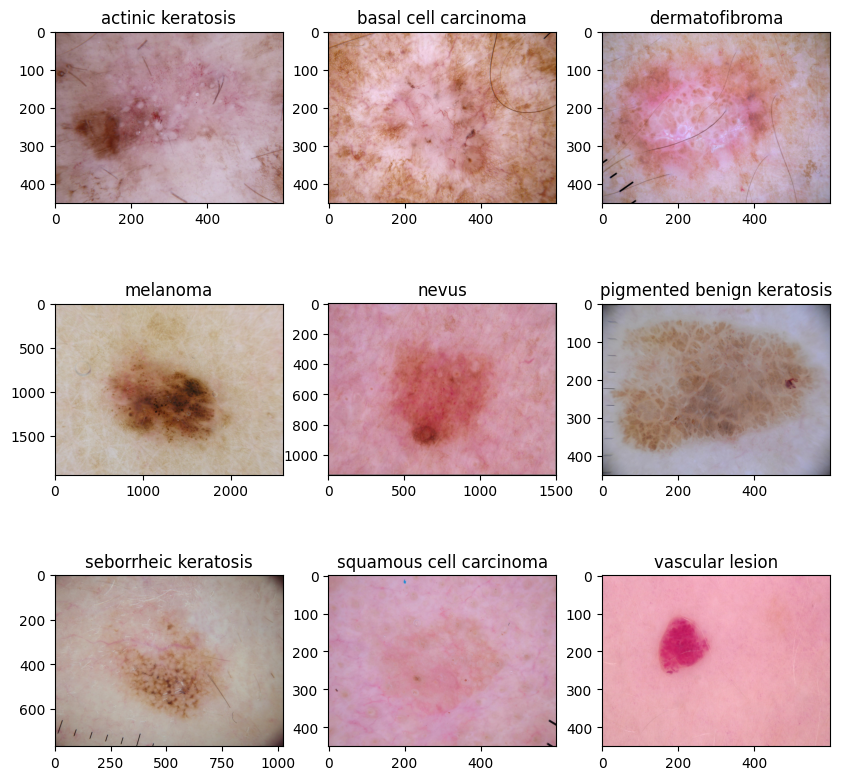

In [ ]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPool2D, Flatten, Dense

# Define the model
model = Sequential([
    Rescaling(1.0/255, input_shape=(img_height, img_width, 3))  # No experimental module needed
])

model.add(Conv2D(32, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Define the optimizer
opt = Adam(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer=opt,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      13,108,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,686,025 (56.02 MB)

 Trainable params: 14,686,025 (56.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 244s 896ms/step - accuracy: 0.1733 - loss: 2.1034 - val_accuracy: 0.1924 - val_loss: 2.0062
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2108 - loss: 1.9796 - val_accuracy: 0.2998 - val_loss: 1.8026
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3139 - loss: 1.7793 - val_accuracy: 0.2819 - val_loss: 1.8903
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3417 - loss: 1.7750 - val_accuracy: 0.3960 - val_loss: 1.6232
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3919 - loss: 1.6286 - val_accuracy: 0.4430 - val_loss: 1.5910
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4277 - loss: 1.5619 - val_accuracy: 0.4430 - val_loss: 1.5876
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4589 - loss: 1.4978 - val_accuracy: 0.4474 - val_loss: 1.4984
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4913 - loss: 1.4831 - val_accuracy: 0.5123 

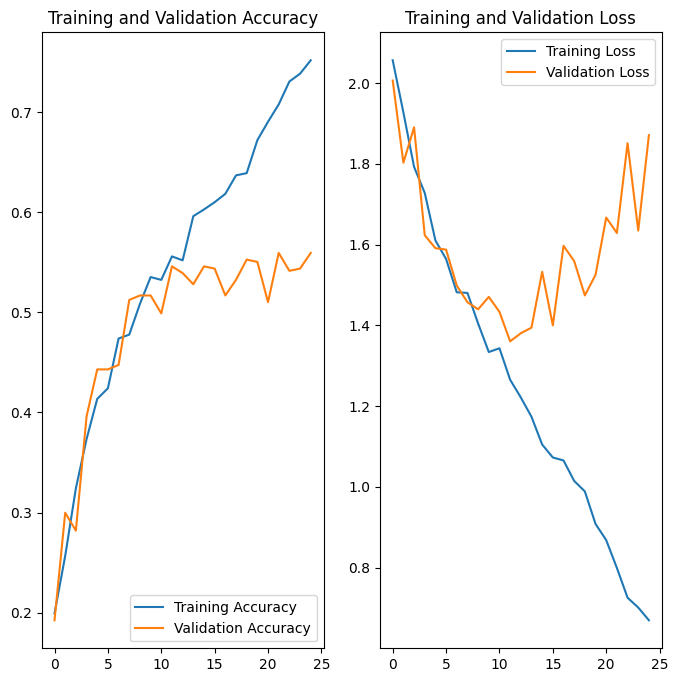

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical",
                          input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ]
)


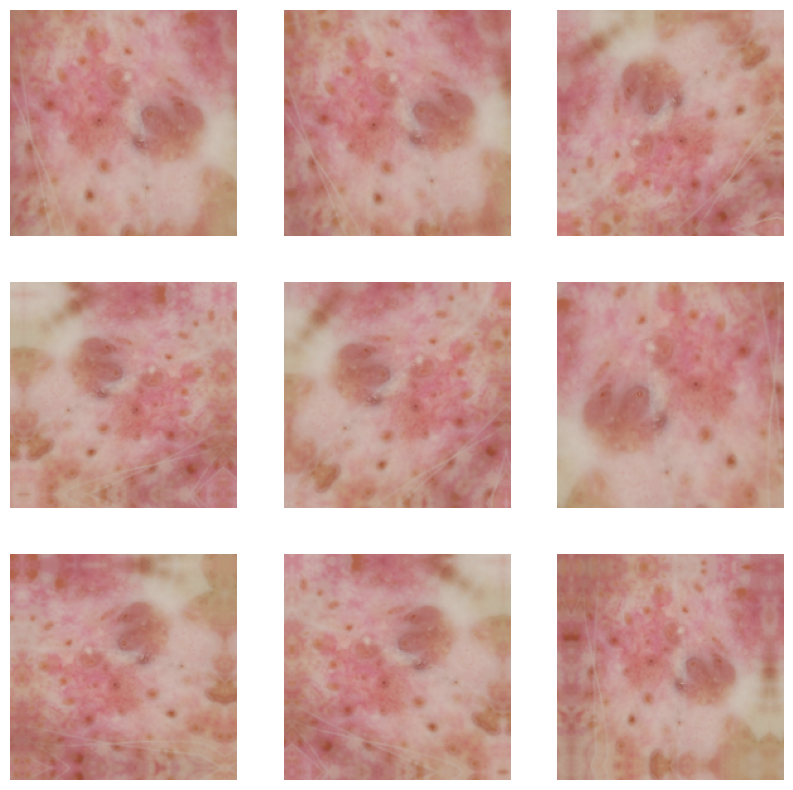

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = 9

model = Sequential()
# Add data augmentation
model.add(data_augmentation)
# Add rescaling
model.add(layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(units=num_classes, activation="softmax"))


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Correcting the optimizer
opt = Adam(learning_rate=0.001)

# Compiling the model
model.compile(
    optimizer=opt,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.1605 - loss: 2.2942 - val_accuracy: 0.1924 - val_loss: 2.0365
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.2084 - loss: 2.0129 - val_accuracy: 0.2438 - val_loss: 1.9985
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.2440 - loss: 1.9751 - val_accuracy: 0.3110 - val_loss: 1.8121
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.2917 - loss: 1.9237 - val_accuracy: 0.3356 - val_loss: 1.7630
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.3497 - loss: 1.7394 - val_accuracy: 0.3960 - val_loss: 1.6426
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.3863 - loss: 1.6750 - val_accuracy: 0.4519 - val_loss: 1.5903
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.4407 - loss: 1.5574 - val_accuracy: 0.4206 - val_loss: 1.6498
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.4351 - loss: 1.5644 - val_accuracy: 0.4899 - 

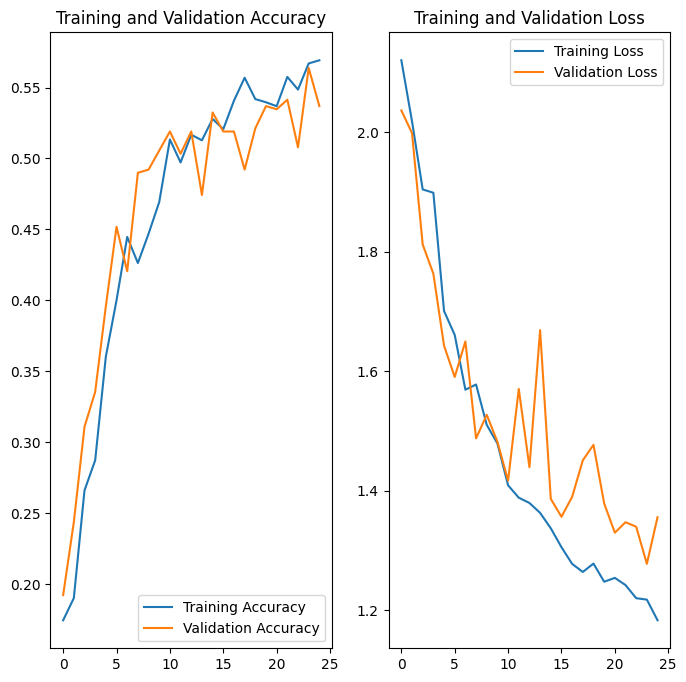

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

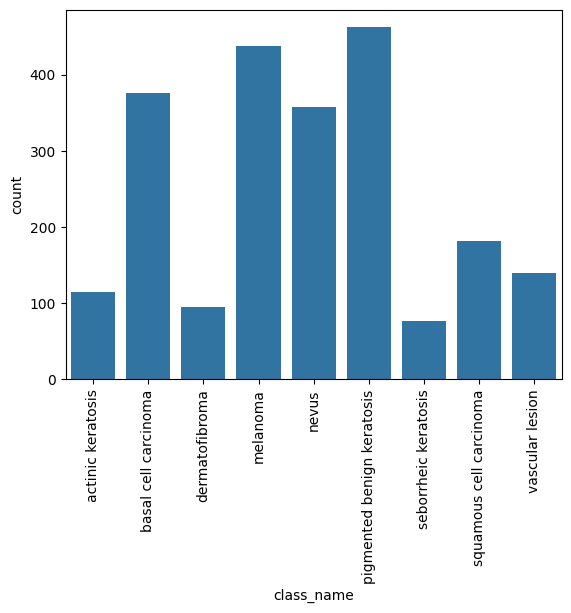

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
!pip install Augmentor

In [ ]:
output_directory = '/content/gdrive/MyDrive/Skin cancer ISIC Augmented/' + i + '/output/'


TypeError: can only concatenate str (not "int") to str

In [ ]:
from google.colab import drive
import Augmentor

# Mount Google Drive if saving to Drive
drive.mount('/content/gdrive')

path_to_training_dataset = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

# Adjust output directory to Google Drive or Colab local storage
output_base_directory = '/content/gdrive/MyDrive/Skin cancer ISIC Augmented/'  # Save in Google Drive
# output_base_directory = '/content/data/'  # Save in Colab local storage

class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] # Replace with your class names

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory=output_base_directory + i + '/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC Augmented/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A3FDE788AC0>: 100%|██████████| 1000/1000 [00:37<00:00, 26.60 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC Augmented/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A3FEE4A4520>: 100%|██████████| 1000/1000 [00:40<00:00, 24.56 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC Augmented/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A3FEE4F5F00>: 100%|██████████| 1000/1000 [00:40<00:00, 24.40 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC Augmented/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A400095A290>: 100%|██████████| 1000/1000 [02:53<00:00,  5.78 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC Augmented/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7A3FEE409990>: 100%|██████████| 1000/1000 [02:29<00:00,  6.69 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC Augmented/pigmented benign keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A406F7A57E0>: 100%|██████████| 1000/1000 [00:38<00:00, 25.80 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC Augmented/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A401E56C250>: 100%|██████████| 1000/1000 [01:21<00:00, 12.23 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC Augmented/squamous cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A401E519990>: 100%|██████████| 1000/1000 [00:38<00:00, 25.89 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC Augmented/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A3FEE490AF0>: 100%|██████████| 1000/1000 [00:40<00:00, 24.59 Samples/s]


In [ ]:
output_dir = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC Augmented/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

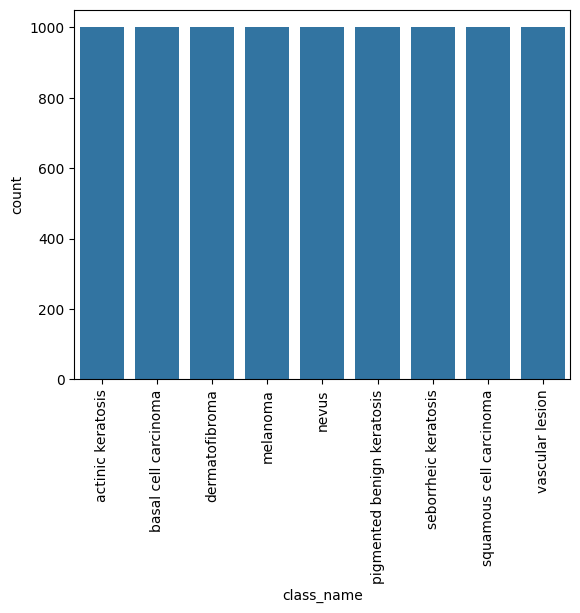

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, Rescaling

num_classes = 9

# Model definition
model = Sequential([
    Rescaling(1.0/255, input_shape=(None, None, 3))  # Allow any input size
])

# Convolutional layers with pooling and dropout
model.add(Conv2D(32, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

# Replace Flatten with GlobalAveragePooling2D
model.add(GlobalAveragePooling2D())  # This ensures a fixed-size output regardless of image size

# Fully connected layers
model.add(Dense(1024, activation="relu"))
model.add(Dense(units=num_classes, activation='softmax'))  # Output layer for multi-class classification

# Model summary
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, None, None, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, None, None, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,103,113 (8.02 MB)

 Trainable params: 2,103,113 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Define optimizer with correct parameter
opt = Adam(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer=opt,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

NameError: name 'model' is not defined

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step


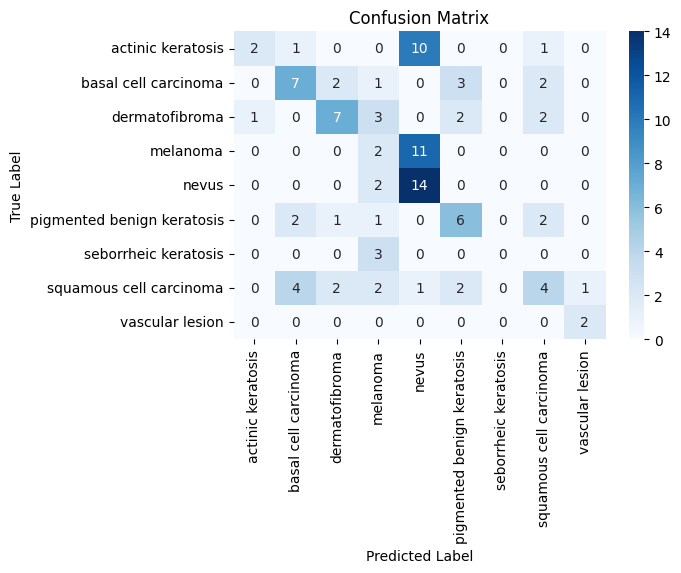

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.67      0.14      0.24        14
      basal cell carcinoma       0.50      0.47      0.48        15
            dermatofibroma       0.58      0.47      0.52        15
                  melanoma       0.14      0.15      0.15        13
                     nevus       0.39      0.88      0.54        16
pigmented benign keratosis       0.46      0.50      0.48        12
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.36      0.25      0.30        16
           vascular lesion       0.67      1.00      0.80         2

                  accuracy                           0.42       106
                 macro avg       0.42      0.43      0.39       106
              weighted avg       0.44      0.42      0.39       106



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the class names
class_names = train_ds.class_names

# Prepare test data (if not already preprocessed)
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_classes, target_names=class_names))


In [ ]:
# Save the model
model.save('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/skin_cancer_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/skin_cancer_model.h5')


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step


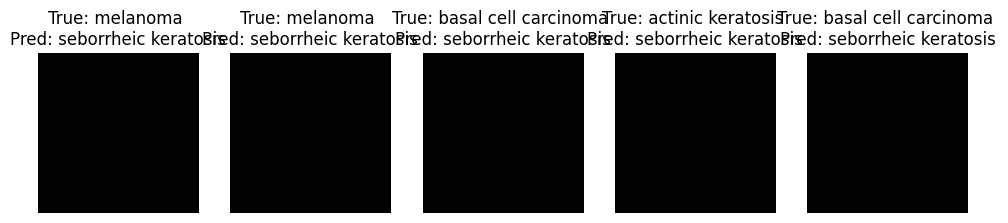

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        20
      basal cell carcinoma       0.00      0.00      0.00        20
            dermatofibroma       0.00      0.00      0.00        19
                  melanoma       0.00      0.00      0.00        21
                     nevus       0.00      0.00      0.00        17
pigmented benign keratosis       0.00      0.00      0.00        19
      seborrheic keratosis       0.03      1.00      0.06         4
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.00      0.00      0.00         4

                  accuracy                           0.03       140
                 macro avg       0.00      0.11      0.01       140
              weighted avg       0.00      0.03      0.00       140



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

sample_images = []
sample_labels = []
class_names = list(test_ds.class_indices.keys())  # List of class names from test_ds

# Loop through test_ds directly
for i, (images, labels) in enumerate(test_ds):
    if i == 5:  # Limit to 5 batches, adjust as needed
        break
    sample_images.append(images)  # No need to call .numpy()
    sample_labels.append(labels)  # No need to call .numpy()

# Convert to numpy arrays
sample_images = np.concatenate(sample_images, axis=0)
sample_labels = np.concatenate(sample_labels, axis=0)

# Make predictions using the trained model
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Visualizing the results
plt.figure(figsize=(12,12))
for i in range(5):  # Adjust to the number of samples you want to visualize
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i].astype("uint8"))
    plt.title(f"True: {class_names[np.argmax(sample_labels[i])]} \nPred: {class_names[predicted_classes[i]]}")
    plt.axis("off")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(np.argmax(sample_labels, axis=1), predicted_classes, target_names=class_names))
